#                                                           Improving Delivery Rate Performance on Olist e-Commerce
Alpha Team - DTIDSOL-02

- Josephine
- Rio
- Widya


### **Contents**

1. Business Problem Understanding
2. Data Cleaning and Understanding
3. EDA
4. Data analysis
5. Summary
6. Conclusion 
7. Limitation
8. Recommendations

****

# Problem Statement

Background and aim of analysis
Business problem identification 

# Data Understanding & Cleaning

## Import Libraries & Datasets

In [128]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, kstest
import statsmodels.api as sm
import os
import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)

In [129]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load original (raw) datasets:

In [130]:
original_df_orders           = read_olist_csv('../data/original_data/olist_orders_dataset.csv')
original_df_customers        = read_olist_csv('../data/original_data/olist_customers_dataset.csv')
original_df_order_items      = read_olist_csv('../data/original_data/olist_order_items_dataset.csv')
original_df_order_payments   = read_olist_csv('../data/original_data/olist_order_payments_dataset.csv')
original_df_reviews          = read_olist_csv('../data/original_data/olist_order_reviews_dataset.csv')
original_df_products         = read_olist_csv('../data/original_data/olist_products_dataset.csv')
original_df_prod_cat_tr      = read_olist_csv('../data/original_data/product_category_name_translation.csv')
original_df_sellers          = read_olist_csv('../data/original_data/olist_sellers_dataset.csv')
original_df_geolocation      = read_olist_csv('../data/original_data/olist_geolocation_dataset.csv')

Load cleaned datasets

In [131]:
cleaned_delivered_df_orders           = read_olist_csv('../data/cleaned_data/olist_orders_dataset.csv')
cleaned_df_customers        = read_olist_csv('../data/cleaned_data/olist_customers_dataset.csv')
cleaned_delivered_df_order_items      = read_olist_csv('../data/cleaned_data/olist_order_items_dataset.csv')
cleaned_delivered_df_order_payments   = read_olist_csv('../data/cleaned_data/olist_order_payments_dataset.csv')
cleaned_delivered_df_reviews          = read_olist_csv('../data/cleaned_data/olist_order_reviews_dataset.csv')
cleaned_df_products         = read_olist_csv('../data/cleaned_data/olist_products_dataset.csv')
cleaned_df_prod_cat_tr      = read_olist_csv('../data/cleaned_data/product_category_name_translation.csv')
cleaned_df_sellers          = read_olist_csv('../data/cleaned_data/olist_sellers_dataset.csv')
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

Merge all datasets

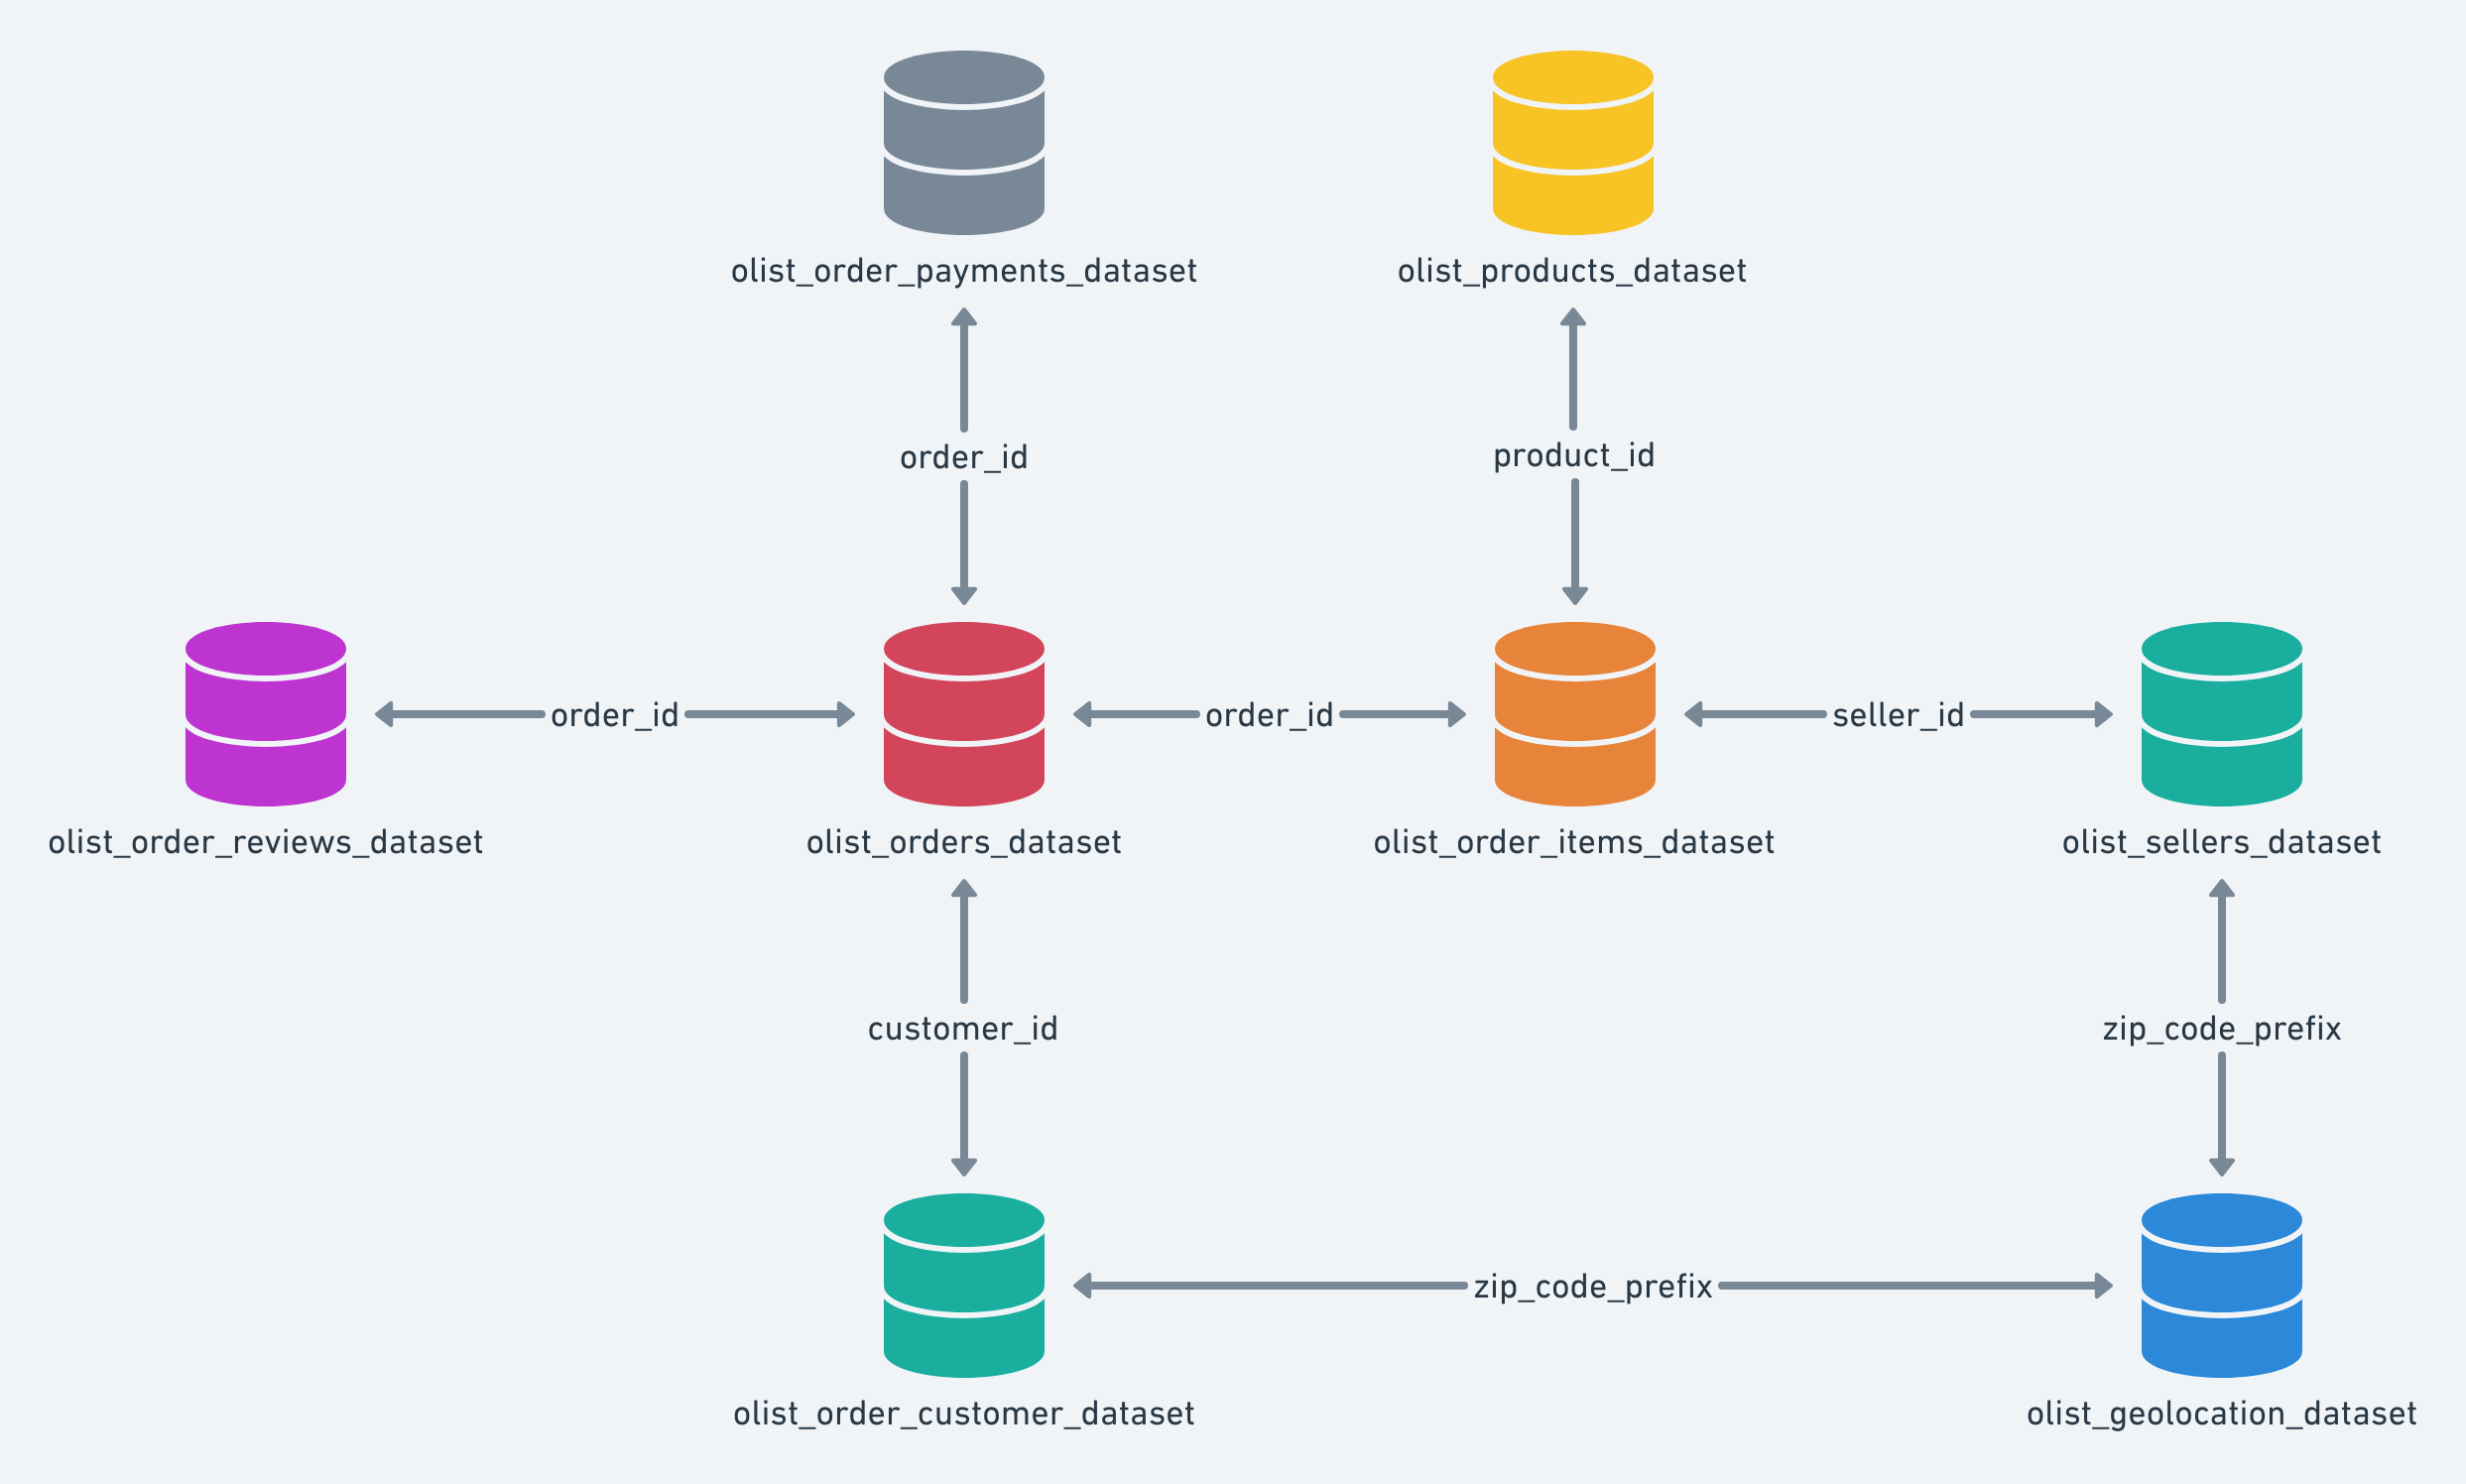

Orders with Customers

In [132]:
# Merge orders + customers (1:1)
merged_orders_customers = cleaned_delivered_df_orders.merge(
    cleaned_df_customers,
    on='customer_id',
    how='left',
    indicator=True
)
print("orders⇄customers:", merged_orders_customers['_merge'].value_counts())
assert (merged_orders_customers['_merge'] == 'both').all(), "⚠️ Some orders missing customers!"
merged_orders_customers.drop(columns=['_merge'], inplace=True)

display(merged_orders_customers.head())

orders⇄customers: _merge
both          96282
left_only         0
right_only        0
Name: count, dtype: int64


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  
0                      3149                sao paulo             SP  
1                     47813                barreiras             BA  
2                     75265               vianopolis             GO  
3                     59296  sao goncalo do amarante             RN  
4                      9195              santo andre             SP

In [133]:
merged_orders_customers.isna().sum()  # Check for any missing values in the merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

Order Items with Products

In [134]:
# Enrich order_items with products (1:1)
enriched_order_items = cleaned_delivered_df_order_items.merge(
    cleaned_df_products,
    on='product_id',
    how='left',
    indicator=True
)

print("order_items⇄products:", enriched_order_items['_merge'].value_counts())
# assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing products!"
# enriched_order_items.drop(columns=['_merge'], inplace=True)

display(enriched_order_items.head())

order_items⇄products: _merge
both          109936
left_only         17
right_only         0
Name: count, dtype: int64


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value product_category_name  \
0 2017-09-19 09:45:35   58.90          13.29            cool_stuff   
1 2017-05-03 11:05:13  239.90          19.93              pet_shop   
2 2018-01-18 14:48:30  199.00          17.87      moveis_decoracao   
3 2018-08-15 10:10:18   12.99          12.79            perfumaria   
4 2017-02-13 13:57:51  199.90          18.14    ferramentas_jardim   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 58.0                       598.0                 4.0   
1                 56.0                       239.0                 2.0   
2                 59.0                       695.0                 2.0   
3                 42.0                       480.0                 1.0   
4                 59.0                       409.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1           30000.0               50.0               30.0              40.0   
2            3050.0               33.0               13.0              33.0   
3             200.0               16.0               10.0              15.0   
4            3750.0               35.0               40.0              30.0   

  _merge  
0   both  
1   both  
2   both  
3   both  
4   both

In [135]:
enriched_order_items.isna().sum()  # Check for any missing values in the enriched DataFrame

order_id                       0
order_item_id                  0
product_id                     0
seller_id                      0
shipping_limit_date            0
price                          0
freight_value                  0
product_category_name         17
product_name_lenght           17
product_description_lenght    17
product_photos_qty            17
product_weight_g              17
product_length_cm             17
product_height_cm             17
product_width_cm              17
_merge                         0
dtype: int64

In [136]:
enriched_order_items[enriched_order_items['_merge'] == 'left_only']  # Check for items without products

order_id  order_item_id  \
6949    101157d4fae1c9fb74a00a5dee265c25              1   
9011    1521c6bb7b1028154c8c67cf80fa809f              1   
28006   415cfaaaa8cea49f934470548797fed1              1   
28007   415cfaaaa8cea49f934470548797fed1              2   
38344   595316a07cd3dea9db7adfcc7e247ae7              1   
47252   6e150190fbe04c642a9cf0b80d83ee16              1   
47790   6f497c40431d5fb0cfbd6c943dd29215              1   
69432   a2456e7f02197951664897a94c87242d              1   
71800   a7a43f469c0d7bdb0a23a82db125aefa              1   
80822   bbfc7badbed2f1828e22b6d629201bd4              1   
82218   bf49f84a0580ef6751e13357776b7ed9              1   
83060   c1424efcde3c9e9febd9e1761667789e              1   
91147   d38dcb503cd4ddc6ce7702552918bd8f              1   
91148   d38dcb503cd4ddc6ce7702552918bd8f              2   
95536   ddf16d77e858a32f36e10c289a28ef61              1   
98111   e3daea0200104991cb979c2fcc509ae7              1   
101255  eb855beb3ac99461f7a076b4c3652472              1   

                              product_id                         seller_id  \
6949    5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
9011    5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
28006   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
28007   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
38344   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
47252   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
47790   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
69432   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
71800   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
80822   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
82218   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
83060   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
91147   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
91148   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
95536   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
98111   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
101255  5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   

       shipping_limit_date  price  freight_value product_category_name  \
6949   2017-04-11 08:02:26   29.0          14.52                   NaN   
9011   2017-04-07 10:10:16   29.0          16.05                   NaN   
28006  2017-04-07 10:35:19   29.0          14.52                   NaN   
28007  2017-04-07 10:35:19   29.0          14.52                   NaN   
38344  2017-08-18 04:26:04   39.0           9.27                   NaN   
47252  2017-06-30 16:45:14   39.0          16.79                   NaN   
47790  2017-04-11 05:55:32   29.0          10.96                   NaN   
69432  2017-04-06 11:50:09   29.0          24.84                   NaN   
71800  2017-08-28 13:15:11   39.0          15.10                   NaN   
80822  2017-07-18 04:04:10   39.0          11.85                   NaN   
82218  2017-07-09 21:35:18   39.0          15.10                   NaN   
83060  2017-04-14 02:45:36   29.0          14.52                   NaN   
91147  2017-06-09 17:55:13   39.0          15.10                   NaN   
91148  2017-06-09 17:55:13   39.0          15.10                   NaN   
95536  2017-05-02 10:50:08   29.0          14.52                   NaN   
98111  2017-04-06 14:22:36   29.0          10.96                   NaN   
101255 2017-03-30 16:03:46   29.0          14.52                   NaN   

        product_name_lenght  product_description_lenght  product_photos_qty  \
6949                    NaN                         NaN                 NaN   
9011                    NaN                         NaN                 N

In [137]:
# Remove order items that don't have matching products
print(f"Removing {(enriched_order_items['_merge'] == 'left_only').sum()} order items without matching products")
enriched_order_items = enriched_order_items[enriched_order_items['_merge'] == 'both']

Removing 17 order items without matching products


In [138]:
enriched_order_items.drop(columns=['_merge'], inplace=True)
enriched_order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value product_category_name  \
0 2017-09-19 09:45:35   58.90          13.29            cool_stuff   
1 2017-05-03 11:05:13  239.90          19.93              pet_shop   
2 2018-01-18 14:48:30  199.00          17.87      moveis_decoracao   
3 2018-08-15 10:10:18   12.99          12.79            perfumaria   
4 2017-02-13 13:57:51  199.90          18.14    ferramentas_jardim   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 58.0                       598.0                 4.0   
1                 56.0                       239.0                 2.0   
2                 59.0                       695.0                 2.0   
3                 42.0                       480.0                 1.0   
4                 59.0                       409.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             650.0               28.0                9.0              14.0  
1           30000.0               50.0               30.0              40.0  
2            3050.0               33.0               13.0              33.0  
3             200.0               16.0               10.0              15.0  
4            3750.0               35.0               40.0              30.0

Order Items-Products with Sellers

In [139]:
# Enrich with sellers (1:1)
enriched_order_items = enriched_order_items.merge(
    cleaned_df_sellers,
    on='seller_id',
    how='left',
    indicator=True
)
print("enriched_order_items⇄sellers:", enriched_order_items['_merge'].value_counts())
assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing sellers!"
enriched_order_items.drop(columns=['_merge'], inplace=True)

enriched_order_items⇄sellers: _merge
both          109936
left_only          0
right_only         0
Name: count, dtype: int64


In [140]:
enriched_order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value product_category_name  \
0 2017-09-19 09:45:35   58.90          13.29            cool_stuff   
1 2017-05-03 11:05:13  239.90          19.93              pet_shop   
2 2018-01-18 14:48:30  199.00          17.87      moveis_decoracao   
3 2018-08-15 10:10:18   12.99          12.79            perfumaria   
4 2017-02-13 13:57:51  199.90          18.14    ferramentas_jardim   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 58.0                       598.0                 4.0   
1                 56.0                       239.0                 2.0   
2                 59.0                       695.0                 2.0   
3                 42.0                       480.0                 1.0   
4                 59.0                       409.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1           30000.0               50.0               30.0              40.0   
2            3050.0               33.0               13.0              33.0   
3             200.0               16.0               10.0              15.0   
4            3750.0               35.0               40.0              30.0   

   seller_zip_code_prefix    seller_city seller_state  
0                   27277  volta redonda           SP  
1                    3471      sao paulo           SP  
2                   37564  borda da mata           MG  
3                   14403         franca           SP  
4                   87900         loanda           PR

Orders+Customers with Order Items+Products+Sellers

In [141]:
# Merge orders+customers ⇄ enriched order_items (1:many)
merged_orders_items = merged_orders_customers.merge(
    enriched_order_items,
    on='order_id',
    how='left',
    indicator=True
)
print("(orders+cust)⇄items:", merged_orders_items['_merge'].value_counts())
n_items = len(enriched_order_items)
matched_items = (merged_orders_items['_merge'] == 'both').sum()
assert matched_items == n_items, f"⚠️ Only {matched_items}/{n_items} items matched!"
# assert (merged_orders_items['_merge'] == 'left_only').sum() == 0, "⚠️ Some orders have no items!"
# merged_orders_items.drop(columns=['_merge'], inplace=True)

merged_orders_items.head()

(orders+cust)⇄items: _merge
both          109936
left_only         15
right_only         0
Name: count, dtype: int64


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix  ... product_description_lenght  \
0                      3149  ...                      268.0   
1                     47813  ...                      178.0   
2                     75265  ...                      232.0   
3                     59296  ...                      468.0   
4                      9195  ...                      316.0   

  product_photos_qty  product_weight_g product_length_cm product_height_cm  \
0                4.0             500.0              19.0               8.0   
1                1.0             400.0              19.0              13.0   
2                1.0             420.0              24.0              19.0   
3                3.0             450.0              30.0              10.0   
4                4.0             250.0              51.0              15.0   

  product_width_cm  seller_zip_code_prefix      seller_city seller_state  \
0             13.0                  9350.0             maua           SP   
1             19.0                 31570.0   belo horizonte           SP   
2             21.0                 14840.0          guariba           SP   
3             20.0                 31842.0   belo horizonte           MG   
4             15.0                  8752.0  mogi das cruzes           SP   

   _merge  
0    both  
1    both  
2    both  
3    both  
4    both  

[5 rows x 30 columns]

15 orders has no items because those items were dropped due to missing product information. So, we'll drop these 15 orders

In [142]:
# Check the orders without items
orders_without_items = merged_orders_items[merged_orders_items['_merge'] == 'left_only']
print(f"Number of orders without items: {len(orders_without_items)}")

# Delete orders without items
print(f"Removing {(merged_orders_items['_merge'] == 'left_only').sum()} orders without matching items")
merged_orders_items = merged_orders_items[merged_orders_items['_merge'] == 'both']
merged_orders_items.drop(columns=['_merge'], inplace=True)

# Confirm the shape after removal
print(f"Final shape of merged_orders_items: {merged_orders_items.shape}")
merged_orders_items.head()

Number of orders without items: 15
Removing 15 orders without matching items
Final shape of merged_orders_items: (109936, 29)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix  ... product_name_lenght  \
0                      3149  ...                40.0   
1                     47813  ...                29.0   
2                     75265  ...                46.0   
3                     59296  ...                59.0   
4                      9195  ...                38.0   

  product_description_lenght  product_photos_qty product_weight_g  \
0                      268.0                 4.0            500.0   
1                      178.0                 1.0            400.0   
2                      232.0                 1.0            420.0   
3                      468.0                 3.0            450.0   
4                      316.0                 4.0            250.0   

  product_length_cm product_height_cm  product_width_cm  \
0              19.0               8.0              13.0   
1              19.0              13.0              19.0   
2              24.0              19.0              21.0   
3              30.0              10.0              20.0   
4              51.0              15.0              15.0   

   seller_zip_code_prefix      seller_city  seller_state  
0                  9350.0             maua            SP  
1                 31570.0   belo horizonte            SP  
2                 14840.0          guariba            SP  
3                 31842.0   belo horizonte            MG  
4                  8752.0  mogi das cruzes            SP  

[5 rows x 29 columns]

In [143]:
merged_orders_items.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

Orders+Items+Customers+Sellers+Products with Payments

In [144]:
# Merge that ⇄ payments (1:many)
merged_orders_payments = merged_orders_items.merge(
    cleaned_delivered_df_order_payments,
    on='order_id',
    how='left',
    indicator=True
)
print("with payments:", merged_orders_payments['_merge'].value_counts())
assert not (merged_orders_payments['_merge'] == 'right_only').any(), "⚠️ Orphan payments exist!"
# merged_orders_payments.drop(columns=['_merge'], inplace=True)

merged_orders_payments.head()

with payments: _merge
both          114761
left_only          3
right_only         0
Name: count, dtype: int64


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
2                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
3                    2018-08-13  af07308b275d755c9edb36a90c618231   
4                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   

   customer_zip_code_prefix  ... product_height_cm product_width_cm  \
0                      3149  ...               8.0             13.0   
1                      3149  ...               8.0             13.0   
2                      3149  ...               8.0             13.0   
3                     47813  ...              13.0             19.0   
4                     75265  ...              19.0             21.0   

   seller_zip_code_prefix     seller_city seller_state payment_sequential  \
0                  9350.0            maua           SP                1.0   
1                  9350.0            maua           SP                3.0   
2                  9350.0            maua           SP                2.0   
3                 31570.0  belo horizonte           SP                1.0   
4                 14840.0         guariba           SP                1.0   

   payment_type  payment_installments payment_value  _merge  
0   credit_card                   1.0         18.12    both  
1       voucher                   1.0          2.00    both  
2       voucher                   1.0         18.59    both  
3        boleto                   1.0        141.46    both  
4   credit_card                   3.0        179.12    both  

[5 rows x 34 columns]

In [145]:
merged_orders_payments.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', '_merge'],
      dtype='object')

In [146]:
# Check for orders without payments
merged_orders_payments[merged_orders_payments['_merge'] == 'left_only'][['order_id', 'order_item_id', 'product_id',
                                                                         'payment_sequential', 'payment_type', 'payment_installments', 'payment_value',
                                                                         'price', 'freight_value']]

order_id  order_item_id  \
35511  bfbd0f9bdef84302105ad712db648a6c            1.0   
35512  bfbd0f9bdef84302105ad712db648a6c            2.0   
35513  bfbd0f9bdef84302105ad712db648a6c            3.0   

                             product_id  payment_sequential payment_type  \
35511  5a6b04657a4c5ee34285d1e4619a96b4                 NaN          NaN   
35512  5a6b04657a4c5ee34285d1e4619a96b4                 NaN          NaN   
35513  5a6b04657a4c5ee34285d1e4619a96b4                 NaN          NaN   

       payment_installments  payment_value  price  freight_value  
35511                   NaN            NaN  44.99           2.83  
35512                   NaN            NaN  44.99           2.83  
35513                   NaN            NaN  44.99           2.83

In [147]:
original_df_order_payments[original_df_order_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']

Empty DataFrame
Columns: [order_id, payment_sequential, payment_type, payment_installments, payment_value]
Index: []

Reasoning for keeping the row:

There is 1 order (3 items) that contains missing payment info, even on the original payments dataset. The `payment_value` can be inferred by calculating `price + freight_value`. However, the rest of the info can only be imputed with synthetic values. So, we'll infer what we can and flag this order that it contains synthetic payment info.

In [148]:
# original_df_order_payments['payment_type'].value_counts()

In [149]:
# missing_payment_mask = merged_orders_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c'

# # Calculate the payment value from price + freight_value
# merged_orders_payments.loc[missing_payment_mask, 'payment_value'] = (
#     merged_orders_payments.loc[missing_payment_mask, 'price'] + 
#     merged_orders_payments.loc[missing_payment_mask, 'freight_value']
# )

# # Set payment type to 'not_defined' (synthetic value, but this category exists in the original dataset)
# merged_orders_payments.loc[missing_payment_mask, 'payment_type'] = 'not_defined'

# # Add a flag to indicate this order has synthetic payment data
# merged_orders_payments['missing_payment_details'] = False
# merged_orders_payments.loc[missing_payment_mask, 'missing_payment_details'] = True

# merged_orders_payments[missing_payment_mask]

Delete the row approach:

In [150]:
# Delete the 3 rows with missing payment info instead of keeping them
print(f"Removing {(merged_orders_payments['_merge'] == 'left_only').sum()} orders without payment information")
merged_orders_payments = merged_orders_payments[merged_orders_payments['_merge'] == 'both']

Removing 3 orders without payment information


In [151]:
merged_orders_payments.drop(columns=['_merge'], inplace=True)
merged_orders_payments.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
2                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
3                    2018-08-13  af07308b275d755c9edb36a90c618231   
4                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   

   customer_zip_code_prefix  ... product_length_cm product_height_cm  \
0                      3149  ...              19.0               8.0   
1                      3149  ...              19.0               8.0   
2                      3149  ...              19.0               8.0   
3                     47813  ...              19.0              13.0   
4                     75265  ...              24.0              19.0   

   product_width_cm seller_zip_code_prefix     seller_city seller_state  \
0              13.0                 9350.0            maua           SP   
1              13.0                 9350.0            maua           SP   
2              13.0                 9350.0            maua           SP   
3              19.0                31570.0  belo horizonte           SP   
4              21.0                14840.0         guariba           SP   

   payment_sequential  payment_type payment_installments  payment_value  
0                 1.0   credit_card                  1.0          18.12  
1                 3.0       voucher                  1.0           2.00  
2                 2.0       voucher                  1.0          18.59  
3                 1.0        boleto                  1.0         141.46  
4                 1.0   credit_card                  3.0         179.12  

[5 rows x 33 columns]

In [152]:
merged_orders_payments.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

Orders+Items+Customers+Sellers+Products+Payments with Reviews

In [153]:
# Merge enriched_orders ⇄ reviews (1:1)
merged_orders_reviews = merged_orders_payments.merge(
    cleaned_delivered_df_reviews,
    on='order_id',
    how='left',
    indicator=True
)
print("with reviews:", merged_orders_reviews['_merge'].value_counts())
assert not (merged_orders_reviews['_merge'] == 'right_only').any(), "⚠️ Orphan reviews exist!"
# merged_orders_reviews.drop(columns=['_merge'], inplace=True)

merged_orders_reviews.head()

with reviews: _merge
both          113721
left_only       1372
right_only         0
Name: count, dtype: int64


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
2                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
3                    2018-08-13  af07308b275d755c9edb36a90c618231   
4                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   

   customer_zip_code_prefix  ... payment_type payment_installments  \
0                      3149  ...  credit_card                  1.0   
1                      3149  ...      voucher                  1.0   
2                      3149  ...      voucher                  1.0   
3                     47813  ...       boleto                  1.0   
4                     75265  ...  credit_card                  3.0   

   payment_value                         review_id review_score  \
0          18.12  a54f0611adc9ed256b57ede6b6eb5114          4.0   
1           2.00  a54f0611adc9ed256b57ede6b6eb5114          4.0   
2          18.59  a54f0611adc9ed256b57ede6b6eb5114          4.0   
3         141.46  8d5266042046a06655c8db133d120ba5          4.0   
4         179.12  e73b67b67587f7644d5bd1a52deb1b01          5.0   

  review_comment_title  \
0                  NaN   
1                  NaN   
2                  NaN   
3     Muito boa a loja   
4                  NaN   

                                                                                                                                                       review_comment_message  \
0  Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.   
1  Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.   
2  Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.   
3                                                                                                                                                        Muito bom o produto.   
4                                                                                                                                                                         NaN   

   review_creation_date review_answer_timestamp  _merge  
0            2017-10-11     2017-10-12 03:43:48    both  
1            2017-10-11     2017-10-12 03:43:48    both  
2            2017-10-11     2017-10-12 03:43:48    both  
3            2018-08-08     2018-08-08 18:37:50    both  
4            2018-08-18     2018-08-22 19:07:58    both  

[5 rows x 40 col

In [154]:
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only']

order_id                       customer_id  \
19      403b97836b0c04a622354cf531062e5f  738b086814c6fcc74b8cc583f8516ee3   
65      a685d016c8a26f71a0bb67821070e398  911e4c37f5cafe1604fe6767034bf1ae   
98      b8801cccd8068de30112e4f49903d74a  f26a435864aebedff7f7c84f82ee229f   
209     ce9feeba53c652dd6569cca62e2bb287  f7398fc942c8fa80e5419ae52e49f7fb   
287     7e3e92dc3eaf5389f32da97228f7dd0e  62d50e9a714ac024c196d9548594e2aa   
...                                  ...                               ...   
114635  2fcdb0c004a2a538d3dd724ea76916bd  cf826be53b1fe4a39bc33c7f5f827835   
114735  2f2df159f26ddb73d55ee72372200d3e  86a7245fffe6a418ca1658a13ecc4531   
114808  129c72226e320a7bf5b89efce442afd5  46dbd6b44084696774eb0bc59352069a   
114839  f0dd9af88d8ef5a8e4670fbbedaf19c4  30ddb50bd22ee927ebe308ea3da60735   
114863  dff2b9b8d7cfc595836945e1443789c3  2436fb2666a65fbacae82532e797cabf   

       order_status order_purchase_timestamp   order_approved_at  \
19        delivered      2018-01-02 19:00:43 2018-01-02 19:09:04   
65        delivered      2017-03-13 18:14:36 2017-03-13 18:14:36   
98        delivered      2017-07-30 03:06:35 2017-07-30 03:25:08   
209       delivered      2018-04-15 19:42:06 2018-04-15 19:55:20   
287       delivered      2017-07-02 20:47:24 2017-07-02 21:03:55   
...             ...                      ...                 ...   
114635    delivered      2017-11-22 11:39:00 2017-11-22 11:49:05   
114735    delivered      2017-07-17 01:19:50 2017-07-17 01:30:09   
114808    delivered      2018-02-12 03:09:04 2018-02-12 03:48:19   
114839    delivered      2017-09-02 20:38:29 2017-09-05 04:24:12   
114863    delivered      2018-07-16 12:59:02 2018-07-17 04:21:00   

       order_delivered_carrier_date order_delivered_customer_date  \
19              2018-01-03 18:19:09           2018-01-20 01:38:59   
65              2017-03-22 14:03:09           2017-04-06 13:37:16   
98              2017-07-31 16:42:54           2017-08-01 14:27:31   
209             2018-04-19 14:32:30           2018-04-20 23:12:11   
287             2017-07-03 11:42:08           2017-07-11 20:22:31   
...                             ...                           ...   
114635          2017-11-23 22:58:51           2017-12-15 00:23:25   
114735          2017-07-17 22:14:50           2017-07-26 09:44:00   
114808          2018-02-15 05:41:47           2018-02-28 17:07:46   
114839          2017-09-14 23:13:41           2017-09-15 14:59:50   
114863          2018-07-17 15:08:00           2018-07-20 20:41:32   

       order_estimated_delivery_date                customer_unique_id  \
19                        2018-02-06  6e26bbeaa107ec34112c64e1ee31c0f5   
65                        2017-03-30  51838d41add414a0b1b989b7d251d9ee   
98                        2017-08-16  bb4d84a2b45b22ed710ac8c0dec63d1a   
209                       2018-04-26  d01cf8c6c7c836c5dd9320585928f42b   
287                       2017-07-25  ba77e9b6506636dcbd03e463d4786f24   
...                              ...                               ...   
114635                    2017-12-18  d92462d83762d5e5c112bccc344119e6   
114735                    2017-08-09  1d532194f005426adcdf6d969640d56e   
114808                    2018-03-12  ae8482b27b2119e2c3278f5ddf9c1024   
114839                    2017-09-19  1d627d8a6e1e33ea8eeeb7a17d998660   
114863                    2018-08-07  9b352d0736779ff0e21fcbd59a7141b3   

        customer_zip_code_prefix  ... payment_type payment_installments  \
19                         21381  ...  credit_card                 10.0   
65                         13068  ...       boleto                  1.0   
98                          8552  ...  credit_card                  2.0   
209                         6414  ...  credit_card                  1.0   
287                        95059  ...  credit_card                  4.0   
...                          ...  ...          ...                  ...   
114635                     65940  .

There are 1372 order items that have no reviews. This is fine since reviews are optional. So, we'll introduce a flag `has_review` to mark if an order item has a review or not.

In [155]:
# Add an explicit flag
merged_orders_reviews['has_review'] = merged_orders_reviews['review_id'].notna()
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only'].head()

order_id                       customer_id  \
19   403b97836b0c04a622354cf531062e5f  738b086814c6fcc74b8cc583f8516ee3   
65   a685d016c8a26f71a0bb67821070e398  911e4c37f5cafe1604fe6767034bf1ae   
98   b8801cccd8068de30112e4f49903d74a  f26a435864aebedff7f7c84f82ee229f   
209  ce9feeba53c652dd6569cca62e2bb287  f7398fc942c8fa80e5419ae52e49f7fb   
287  7e3e92dc3eaf5389f32da97228f7dd0e  62d50e9a714ac024c196d9548594e2aa   

    order_status order_purchase_timestamp   order_approved_at  \
19     delivered      2018-01-02 19:00:43 2018-01-02 19:09:04   
65     delivered      2017-03-13 18:14:36 2017-03-13 18:14:36   
98     delivered      2017-07-30 03:06:35 2017-07-30 03:25:08   
209    delivered      2018-04-15 19:42:06 2018-04-15 19:55:20   
287    delivered      2017-07-02 20:47:24 2017-07-02 21:03:55   

    order_delivered_carrier_date order_delivered_customer_date  \
19           2018-01-03 18:19:09           2018-01-20 01:38:59   
65           2017-03-22 14:03:09           2017-04-06 13:37:16   
98           2017-07-31 16:42:54           2017-08-01 14:27:31   
209          2018-04-19 14:32:30           2018-04-20 23:12:11   
287          2017-07-03 11:42:08           2017-07-11 20:22:31   

    order_estimated_delivery_date                customer_unique_id  \
19                     2018-02-06  6e26bbeaa107ec34112c64e1ee31c0f5   
65                     2017-03-30  51838d41add414a0b1b989b7d251d9ee   
98                     2017-08-16  bb4d84a2b45b22ed710ac8c0dec63d1a   
209                    2018-04-26  d01cf8c6c7c836c5dd9320585928f42b   
287                    2017-07-25  ba77e9b6506636dcbd03e463d4786f24   

     customer_zip_code_prefix  ... payment_installments payment_value  \
19                      21381  ...                 10.0       1376.45   
65                      13068  ...                  1.0         99.26   
98                       8552  ...                  2.0         27.77   
209                      6414  ...                  1.0         56.86   
287                     95059  ...                  4.0         95.21   

     review_id review_score review_comment_title review_comment_message  \
19         NaN          NaN                  NaN                    NaN   
65         NaN          NaN                  NaN                    NaN   
98         NaN          NaN                  NaN                    NaN   
209        NaN          NaN                  NaN                    NaN   
287        NaN          NaN                  NaN                    NaN   

     review_creation_date  review_answer_timestamp     _merge  has_review  
19                    NaT                      NaT  left_only       False  
65                    NaT                      NaT  left_only       False  
98                    NaT                      NaT  left_only       False  
209                   NaT                      NaT  left_only       False  
287                   NaT                      NaT  left_only       False  

[5 rows x 41 columns]

In [156]:
merged_orders_reviews.drop(columns=['_merge'], inplace=True)
merged_orders_reviews.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


Complete Orders with Product Category Translation

In [157]:
# Merge complete orders ⇄ category translation
merged_orders_translated = merged_orders_reviews.merge(
    cleaned_df_prod_cat_tr,
    on='product_category_name',
    how='left',
    indicator=True
)
print("with category translation:", merged_orders_translated['_merge'].value_counts())
# assert (merged_orders_category['_merge'] == 'both').all(), "⚠️ Missing category translations!"
# merged_orders_category.drop(columns=['_merge'], inplace=True)

merged_orders_translated.head()

with category translation: _merge
both          113455
left_only       1638
right_only         0
Name: count, dtype: int64


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
2                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
3                    2018-08-13  af07308b275d755c9edb36a90c618231   
4                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   

   customer_zip_code_prefix  ... payment_value  \
0                      3149  ...         18.12   
1                      3149  ...          2.00   
2                      3149  ...         18.59   
3                     47813  ...        141.46   
4                     75265  ...        179.12   

                          review_id  review_score review_comment_title  \
0  a54f0611adc9ed256b57ede6b6eb5114           4.0                  NaN   
1  a54f0611adc9ed256b57ede6b6eb5114           4.0                  NaN   
2  a54f0611adc9ed256b57ede6b6eb5114           4.0                  NaN   
3  8d5266042046a06655c8db133d120ba5           4.0     Muito boa a loja   
4  e73b67b67587f7644d5bd1a52deb1b01           5.0                  NaN   

                                                                                                                                                       review_comment_message  \
0  Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.   
1  Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.   
2  Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.   
3                                                                                                                                                        Muito bom o produto.   
4                                                                                                                                                                         NaN   

  review_creation_date  review_answer_timestamp  has_review  \
0           2017-10-11      2017-10-12 03:43:48        True   
1           2017-10-11      2017-10-12 03:43:48        True   
2           2017-10-11      2017-10-12 03:43:48        True   
3           2018-08-08      2018-08-08 18:37:50        True   
4           2018-08-18      2018-08-22 19:07:58        True   

  product_category_name_english  _merge  
0                    housewares    both  
1                    housewares    both  
2                    housewares    both  
3                     perfumery    both  
4          

In [158]:
merged_orders_translated.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'has_review',
       'product_category_name_english', '_merge'],
      dtype='object')

In [159]:
merged_orders_translated[merged_orders_translated['_merge'] == 'left_only'][['product_category_name', 'product_category_name_english']].head(10)

product_category_name  \
126                                unknown_category   
215                                unknown_category   
268                                unknown_category   
309                                unknown_category   
381                                unknown_category   
537                                unknown_category   
598                                unknown_category   
785                                unknown_category   
814                                unknown_category   
1061  portateis_cozinha_e_preparadores_de_alimentos   

     product_category_name_english  
126                            NaN  
215                            NaN  
268                            NaN  
309                            NaN  
381                            NaN  
537                            NaN  
598                            NaN  
785                            NaN  
814                            NaN  
1061                           NaN

1638 order items does not have an English translation for the products that were sold. There's a `unknown_category` value which naturally has no translation, so we can fill the missing values with the exact same value for that case.

In [160]:
# Replace missing English translations for unknown_category
mask_unknown = merged_orders_translated['product_category_name'] == 'unknown_category'
merged_orders_translated.loc[mask_unknown, 'product_category_name_english'] = 'unknown_category'

# Check the result
print(f"Number of items with 'unknown_category': {mask_unknown.sum()}")

Number of items with 'unknown_category': 1615


Apparently, there are 1615 items with no translation simply because their category is unknown. So, there are only 23 items left with purely no translation.

In [161]:
merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()][['product_category_name', 'product_category_name_english']]

product_category_name  \
1061    portateis_cozinha_e_preparadores_de_alimentos   
2560                                         pc_gamer   
8609    portateis_cozinha_e_preparadores_de_alimentos   
10422   portateis_cozinha_e_preparadores_de_alimentos   
12977   portateis_cozinha_e_preparadores_de_alimentos   
13425                                        pc_gamer   
19861   portateis_cozinha_e_preparadores_de_alimentos   
30918   portateis_cozinha_e_preparadores_de_alimentos   
30919   portateis_cozinha_e_preparadores_de_alimentos   
42410                                        pc_gamer   
50777                                        pc_gamer   
61744                                        pc_gamer   
61745                                        pc_gamer   
72660   portateis_cozinha_e_preparadores_de_alimentos   
75068   portateis_cozinha_e_preparadores_de_alimentos   
92047   portateis_cozinha_e_preparadores_de_alimentos   
92347                                        pc_gamer   
92348                                        pc_gamer   
99905   portateis_cozinha_e_preparadores_de_alimentos   
106546  portateis_cozinha_e_preparadores_de_alimentos   
106924  portateis_cozinha_e_preparadores_de_alimentos   
109861                                       pc_gamer   
113724  portateis_cozinha_e_preparadores_de_alimentos   

       product_category_name_english  
1061                             NaN  
2560                             NaN  
8609                             NaN  
10422                            NaN  
12977                            NaN  
13425                            NaN  
19861                            NaN  
30918                            NaN  
30919                            NaN  
42410                            NaN  
50777                            NaN  
61744                            NaN  
61745                            NaN  
72660                            NaN  
75068                            NaN  
92047                            NaN  
92347                            NaN  
92348                            NaN  
99905                            NaN  
106546                           NaN  
106924                           NaN  
109861                           NaN  
113724                           NaN

The only 2 product category with no English translation here is "portateis_cozinha_e_preparadores_de_alimentos" and "pc_gamer". We will manually translate these categories since there are only 2 of them.

In [162]:
# Manually translate the missing product category names
translations = {
    'portateis_cozinha_e_preparadores_de_alimentos': 'portable_kitchen_food_processors',
    'pc_gamer': 'gaming_pc'
}

# Apply the translations
for pt_category, en_category in translations.items():
    mask = merged_orders_translated['product_category_name'] == pt_category
    merged_orders_translated.loc[mask, 'product_category_name_english'] = en_category

# Verify all categories now have translations
missing_translations = merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()]
print(f"Number of items still missing translations: {len(missing_translations)}")

Number of items still missing translations: 0


In [163]:
merged_orders_translated.drop(columns=['_merge'], inplace=True)
merged_orders_translated.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


Final Master Dataset

In [164]:
master_olist_dataset = merged_orders_translated.copy()

# Final check & export
print("Final master table shape:", master_olist_dataset.shape)
master_olist_dataset.to_csv('../data/cleaned_data/master_olist_dataset.csv', index=False)
print("Saved master_olist_dataset.csv")

Final master table shape: (115093, 41)
Saved master_olist_dataset.csv


In [165]:
master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115093 non-null  datetime64[ns]
 6   order_delivered_customer_date  115093 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 8   customer_unique_id             115093 non-null  object        
 9   customer_zip_code_prefix       115093 non-null  int64         
 10  customer_city                  115093 non-null  object        
 11  

# EDA

## Sales

In [166]:
df_sales = master_olist_dataset[['order_id','seller_id', 'customer_id', 'order_status', 'order_purchase_timestamp','price']].copy()

In [167]:
df_sales.head()

order_id                         seller_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9   
1  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9   
2  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9   
3  53cdb2fc8bc7dce0b6741e2150273451  289cdb325fb7e7f891c38608bf9e0962   
4  47770eb9100c2d0c44946d9cf07ec65d  4869f7a5dfa277a7dca6462dcf3b52b2   

                        customer_id order_status order_purchase_timestamp  \
0  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
2  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
3  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37   
4  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49   

    price  
0   29.99  
1   29.99  
2   29.99  
3  118.70  
4  159.90

In [168]:
df_sales.nunique()


order_id                    96266
seller_id                    2965
customer_id                 96266
order_status                    1
order_purchase_timestamp    95745
price                        5857
dtype: int64

In [169]:
# sales per month with number of orders and buyers

df_sales['Year-Month (Purchase)'] = df_sales['order_purchase_timestamp'].dt.to_period('M')
df_sales['Year-Month (Purchase)'] = df_sales['Year-Month (Purchase)'].dt.to_timestamp()

monthly_sales = df_sales.groupby('Year-Month (Purchase)').agg(
    monthly_revenue = ('price','sum'),
    total_orders = ('order_id', 'count'),
    total_buyers = ('customer_id', 'nunique'),
    total_sellers = ('seller_id', 'nunique')
).reset_index()

print("Monthly sales data:")
monthly_sales




Monthly sales data:


Year-Month (Purchase)  monthly_revenue  total_orders  total_buyers  \
0             2016-10-01         41179.54           328           261   
1             2016-12-01            10.90             1             1   
2             2017-01-01        120156.45           965           749   
3             2017-02-01        246365.95          1962          1651   
4             2017-03-01        381774.29          3082          2542   
5             2017-04-01        361207.47          2703          2297   
6             2017-05-01        530113.68          4281          3544   
7             2017-06-01        443331.91          3698          3132   
8             2017-07-01        514498.77          4705          3859   
9             2017-08-01        581117.84          5077          4189   
10            2017-09-01        646540.66          5028          4150   
11            2017-10-01        679135.04          5480          4478   
12            2017-11-01       1027045.57          8852          7288   
13            2017-12-01        754097.64          6457          5513   
14            2018-01-01        962454.49          8382          7069   
15            2018-02-01        864539.29          7812          6555   
16            2018-03-01        996420.80          8360          7003   
17            2018-04-01       1006667.19          8109          6791   
18            2018-05-01       1009792.67          8070          6719   
19            2018-06-01        894596.12          7271          6050   
20            2018-07-01        894155.94          7169          6119   
21            2018-08-01        862925.67          7301          6306   

    total_sellers  
0             128  
1               1  
2             218  
3             401  
4             475  
5             488  
6             562  
7             518  
8             590  
9             683  
10            711  
11            762  
12            937  
13            846  
14            956  
15            928  
16            981  
17           1105  
18           1104  
19           1161  
20           1232  
21           1256

TypeError: 'str' object is not callable

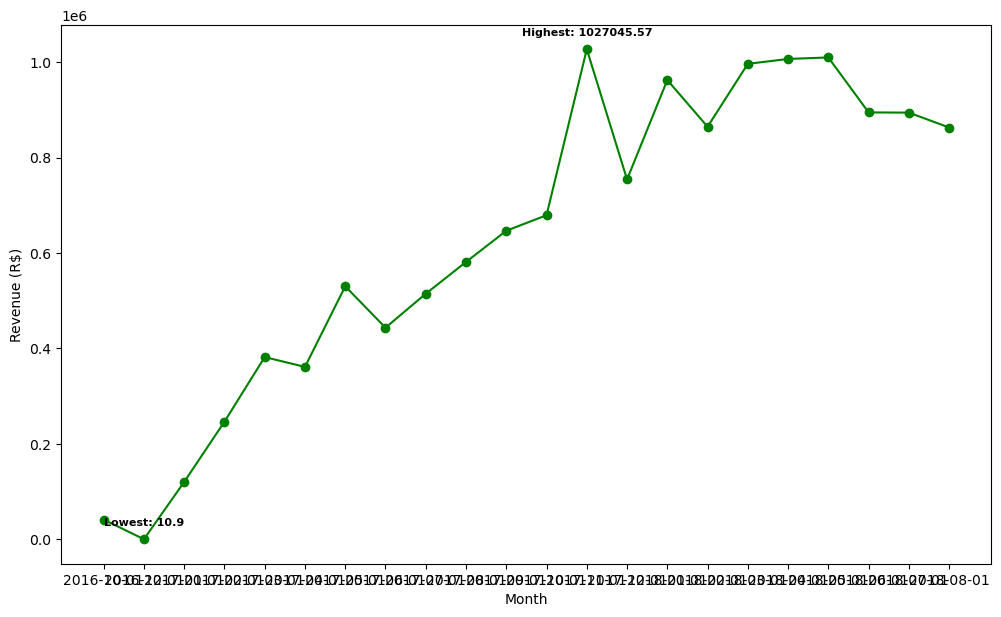

In [170]:
plt.figure(figsize=(12, 7))
monthlyprofit_values = monthly_sales['monthly_revenue'].replace('R$', '').astype(float)
plt.plot(monthly_sales['Year-Month (Purchase)'].astype(str), monthlyprofit_values, marker='o', linestyle='-', color='green',label='Revenue Trend')

# Finding the index of the highest and lowest values
max_index_p = monthlyprofit_values.idxmax()
min_index_p = monthlyprofit_values.idxmin()

# highest and lowest values
plt.annotate(f"Highest: {monthly_sales['monthly_revenue'][max_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[max_index_p], monthlyprofit_values[max_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')
plt.annotate(f"Lowest: {monthly_sales['monthly_revenue'][min_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[min_index_p], monthlyprofit_values[min_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')

plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.title('Olist Revenue (Monthly)', size=16, pad=10, fontweight='bold')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
print('Multilines Chart of Monthly Sales:')

#Plotly figure with multilines chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_orders'],
    mode='lines+markers',
    name='Total Orders'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_buyers'],
    mode='lines+markers',
    name='Total Buyers'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_sellers'],
    mode='lines+markers',
    name='Total Sellers'
))

fig.update_layout(
    title='Total Orders, Buyers, and Sellers (Monthly)', title_x=0.5,
    xaxis_title='Month',
    yaxis_title='Count',
    legend_title='Metric',
    template='plotly_white'
)

Multilines Chart of Monthly Sales:


## Sellers

In [ ]:
# Number of unique seller cities:
state_counts = master_olist_dataset['seller_state'].value_counts().reset_index()
state_counts.columns = ['seller_state', 'count']

fig = px.bar(state_counts, x='seller_state', y='count', 
             title='Number of Sellers by State', 
             labels={'count': 'Number of Sellers'})
fig.show()

In [ ]:
# Top 10 cities by number of sellers, coloured by state:
city_state = master_olist_dataset.groupby(['seller_city', 'seller_state'])['seller_id'].nunique().reset_index()
city_state.columns = ['seller_city', 'seller_state', 'seller_count']

top_city_state = city_state.sort_values('seller_count', ascending=False).head(10)

fig = px.bar(top_city_state, x='seller_count', y='seller_city', color='seller_state',
             title='Top 10 Cities by Number of Sellers (Coloured by State)',
             labels={'seller_count': 'Number of Sellers', 'seller_city': 'City'})
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [ ]:
# Total number of items per seller
seller_kpi = master_olist_dataset.groupby('seller_id').agg(
    total_items=('order_id', 'count'),
    unique_orders=('order_id', 'nunique')
).reset_index()

seller_kpi.head()

seller_id  total_items  unique_orders
0  0015a82c2db000af6aaaf3ae2ecb0532            3              3
1  001cca7ae9ae17fb1caed9dfb1094831          236            195
2  002100f778ceb8431b7a1020ff7ab48f           57             50
3  003554e2dce176b5555353e4f3555ac8            1              1
4  004c9cd9d87a3c30c522c48c4fc07416          202            156

In [ ]:
# Count how many unique sellers each order has
items_per_order = master_olist_dataset.groupby('order_id')['seller_id'].nunique().reset_index(name='unique_seller_count')
items_per_order.head()

order_id  unique_seller_count
0  00010242fe8c5a6d1ba2dd792cb16214                    1
1  00018f77f2f0320c557190d7a144bdd3                    1
2  000229ec398224ef6ca0657da4fc703e                    1
3  00024acbcdf0a6daa1e931b038114c75                    1
4  00042b26cf59d7ce69dfabb4e55b4fd9                    1

In [ ]:
multiple_sellers_orders = items_per_order[items_per_order['unique_seller_count'] > 1]
multiple_sellers_orders = multiple_sellers_orders.sort_values(by='unique_seller_count', ascending=False)
multiple_sellers_orders

order_id  unique_seller_count
10578  1c11d0f4353b31ac3417fbfa5f0f2a8a                    5
10962  1d23106803c48c391366ff224513fb7f                    4
52498  8c2b13adf3f377c8f2b06b04321b0925                    4
96165  ffb8f7de8940249a3221252818937ecb                    3
63533  a98012aa8c697f2bcff9f8c2183e0f2b                    3
...                                 ...                  ...
33438  591083bc42b589c7052118aa83118e76                    2
33382  58e03095584d960583933517a2aae5df                    2
33345  58c4df4904044782bb1361c5cb001538                    2
32836  57638520434d4c12b81d532ad9bf2f1f                    2
48165  804f733828d8587c734a1d8fc5634e06                    2

[1252 rows x 2 columns]

In [ ]:

print(multiple_sellers_orders.shape)

(1252, 2)


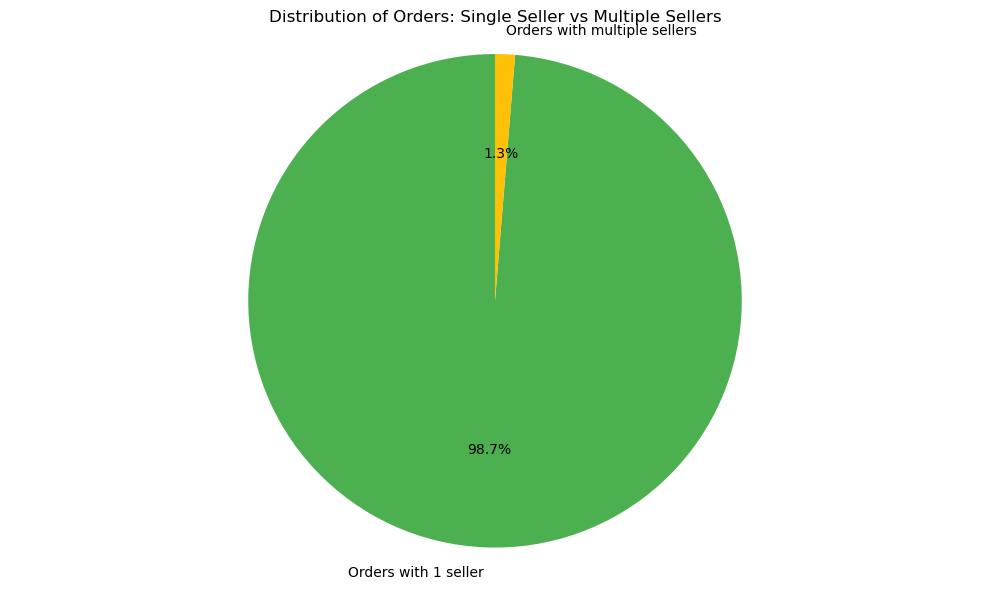

Orders with 1 seller: 95014 (98.70%)
Orders with multiple sellers: 1252 (1.30%)


In [ ]:
# Count the number of orders with 1 seller and orders with multiple sellers
single_seller_orders_count = len(items_per_order[items_per_order['unique_seller_count'] == 1])
multiple_seller_orders_count = len(items_per_order[items_per_order['unique_seller_count'] > 1])

# Create labels and values for the pie chart
labels = ['Orders with 1 seller', 'Orders with multiple sellers']
sizes = [single_seller_orders_count, multiple_seller_orders_count]

# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Orders: Single Seller vs Multiple Sellers')
plt.tight_layout()
plt.show()

# Print the actual numbers
print(f"Orders with 1 seller: {single_seller_orders_count} ({single_seller_orders_count/len(items_per_order)*100:.2f}%)")
print(f"Orders with multiple sellers: {multiple_seller_orders_count} ({multiple_seller_orders_count/len(items_per_order)*100:.2f}%)")

## Customers

In [ ]:
df_customers_geo = master_olist_dataset[['customer_id','customer_unique_id','customer_zip_code_prefix','customer_state','customer_city']].reset_index()


In [ ]:
df_customers_state = master_olist_dataset[['customer_unique_id', 'customer_state']].drop_duplicates().reset_index(drop=True)


In [ ]:
top_state = df_customers_state['customer_state'].value_counts().nlargest(10).reset_index()
top_state

customer_state  count
0             SP  39080
1             RJ  11898
2             MG  10974
3             RS   5149
4             PR   4756
5             SC   3437
6             BA   3154
7             DF   2015
8             ES   1922
9             GO   1889

In [ ]:
# Customer state distribution:
fig = px.histogram(
    df_customers_state,
    x='customer_state',
    title='Number of Customers by State',
    labels={'customer_state': 'State'},
    color='customer_state',                     
    color_discrete_sequence=px.colors.qualitative.Plotly,
      
)

fig.update_layout(
    xaxis_title='State',
    yaxis_title='Number of Customers',
    template='plotly_white'
)   
fig.show()


In [ ]:
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities

customer_city  count
0               sao paulo  18205
1          rio de janeiro   7958
2          belo horizonte   3186
3                brasilia   2414
4                curitiba   1783
5                campinas   1711
6            porto alegre   1610
7                salvador   1473
8               guarulhos   1361
9   sao bernardo do campo   1096
10                niteroi   1031
11            santo andre    896
12                 osasco    867
13                 santos    836
14                goiania    830
15    sao jose dos campos    799
16              fortaleza    727
17               sorocaba    714
18                 recife    684
19                jundiai    671

In [ ]:
# Customer city distribution (top 20):
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities.columns = ['city', 'count']

fig = px.bar(
    top_cities,
    x='city',
    y='count',
    title='Top 20 Customers Cities',
    color='count',
    color_continuous_scale='Oxy'
)

fig.update_layout(
    xaxis_title='Cities',
    yaxis_title='Count',
    template='plotly_white'
)  
fig.show()

##### Customer behaviours 

In [ ]:
#popular products by sales count
popular_products = master_olist_dataset.groupby(['product_id','product_category_name','product_category_name_english']).agg(sales_count=('order_id', 'count'), revenue = ('price','sum')).reset_index()
top10_products_bysales = popular_products.sort_values(by='sales_count', ascending=False).head(10)      
display(top10_products_bysales)

product_id   product_category_name  \
21571  aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao   
19249  99a4788cb24856965c36a24e339b6058         cama_mesa_banho   
8409   422879e10f46682990de24d770e7f83d      ferramentas_jardim   
7188   389d119b48cf3043d311335e499d9c6b      ferramentas_jardim   
6908   368c6c730842d78016ad823897a372db      ferramentas_jardim   
10565  53759a2ecddad2bb87a079a1f1519f73      ferramentas_jardim   
26377  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios   
10592  53b36df67ebb7c41585e8d54d6772e08      relogios_presentes   
2725   154e7e31ebfa092203795c972e5804a6            beleza_saude   
7862   3dd2a17168ec895c781a9191c1e95ad7  informatica_acessorios   

      product_category_name_english  sales_count   revenue  
21571               furniture_decor          529  37743.60  
19249                bed_bath_table          515  45419.96  
8409                   garden_tools          508  27851.62  
7188                   garden_tools          403  22027.49  
6908                   garden_tools          398  21601.10  
10565                  garden_tools          391  21390.70  
26377         computers_accessories          345  47437.46  
10592                 watches_gifts          325  37929.42  
2725                  health_beauty          280   6309.20  
7862          computers_accessories          276  41382.40

In [ ]:
#popular products by revenue
popular_products = master_olist_dataset.groupby(['product_id','product_category_name','product_category_name_english']).agg(sales_count=('order_id', 'count'), revenue = ('price','sum')).reset_index()
top10_products_byrevenue = popular_products.sort_values(by='revenue', ascending=False).head(10)      
display(top10_products_byrevenue)

product_id   product_category_name  \
23496  bb50f2e236e5eea0100680137654686c            beleza_saude   
13718  6cdd53843498f92890544667809f1595            beleza_saude   
26938  d6160fb7873f184099d9bc95e30376af                     pcs   
26377  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios   
19249  99a4788cb24856965c36a24e339b6058         cama_mesa_banho   
4879   25c38557cf793876c5abdd5931f922db                   bebes   
7862   3dd2a17168ec895c781a9191c1e95ad7  informatica_acessorios   
10592  53b36df67ebb7c41585e8d54d6772e08      relogios_presentes   
21571  aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao   
12047  5f504b3a1c75b73d6151be81eb05bdc9              cool_stuff   

      product_category_name_english  sales_count   revenue  
23496                 health_beauty          208  68160.00  
13718                 health_beauty          156  54702.00  
26938                     computers           39  53998.84  
26377         computers_accessories          345  47437.46  
19249                bed_bath_table          515  45419.96  
4879                           baby           44  44829.32  
7862          computers_accessories          276  41382.40  
10592                 watches_gifts          325  37929.42  
21571               furniture_decor          529  37743.60  
12047                    cool_stuff           63  37733.90

In [ ]:
#type of payment

df_payment_type = master_olist_dataset.groupby('payment_type')['order_id'].count().reset_index()

total_reviews = df_payment_type['order_id'].sum()
df_payment_type['percentage (%)'] = (df_payment_type['order_id'] / total_reviews * 100).round(2)

display(df_payment_type)

payment_type  order_id  percentage (%)
0       boleto     22398           19.46
1  credit_card     84901           73.77
2   debit_card      1652            1.44
3      voucher      6142            5.34

In [ ]:
figsegment = go.Figure(data=[go.Pie(
    labels=df_payment_type['payment_type'],  
    values=df_payment_type['percentage (%)'].values,  
    hole=0.4,
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

figsegment.update_traces(textposition='auto')
figsegment.update_layout(
    title_text="Segment Proportion (%)", title_x=0.5,
    showlegend=False
)

figsegment.show()

In [ ]:
#repeat customers

orders_per_customer = master_olist_dataset.groupby('customer_unique_id')['order_id'].nunique()
n_repeat_customers = (orders_per_customer > 1).sum()


n_customers = master_olist_dataset['customer_unique_id'].nunique()

repeat_pcg = n_repeat_customers / n_customers
onetime_pcg = 1 - repeat_pcg

display(f'Total Customers: {n_customers}')
display(f'Total Repeat Customers: {n_repeat_customers}')
display(f'Total One-time Customers: {n_customers - n_repeat_customers}')
display(f'Repeat Customers Percentage / Customer retention: {repeat_pcg:.2%}')
display(f'One time Customers Percentage: {onetime_pcg:.2%}')
display(orders_per_customer.describe())

'Total Customers: 93155'

'Total Repeat Customers: 2793'

'Total One-time Customers: 90362'

'Repeat Customers Percentage / Customer retention: 3.00%'

'One time Customers Percentage: 97.00%'

count    93155.000000
mean         1.033396
std          0.209001
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: order_id, dtype: float64

In [ ]:
#basket size 

#basket size based on order_item_id
n_item_per_order = master_olist_dataset.groupby('order_item_id')['order_id'].count().reset_index()
total_reviews = n_item_per_order['order_id'].sum()
n_item_per_order['percentage (%)'] = (n_item_per_order['order_id'] / total_reviews * 100).round(3)

# Display the result
display(n_item_per_order)

order_item_id  order_id  percentage (%)
0             1.0    100810          87.590
1             2.0     10069           8.749
2             3.0      2332           2.026
3             4.0       958           0.832
4             5.0       450           0.391
5             6.0       255           0.222
6             7.0        60           0.052
7             8.0        37           0.032
8             9.0        29           0.025
9            10.0        26           0.023
10           11.0        18           0.016
11           12.0        13           0.011
12           13.0         8           0.007
13           14.0         7           0.006
14           15.0         5           0.004
15           16.0         3           0.003
16           17.0         3           0.003
17           18.0         3           0.003
18           19.0         3           0.003
19           20.0         3           0.003
20           21.0         1           0.001

In [ ]:

fig = px.histogram(master_olist_dataset, x="order_item_id",
             color='order_item_id', barmode='relative',
             histfunc='count', text_auto=True,
             height=1000, width=700,
             labels={
                     "order_item_id": "Order Item ID",
                     })

fig.update_traces(textposition='outside',texttemplate="<b>%{y:.2f}</b>")
fig.update_layout(
    title_text="Number of item per order", title_x=0.5,
    barmode="relative",
    uniformtext=dict(mode="hide", minsize=10),
    xaxis={'categoryorder': 'total ascending'}
)
fig.show()

As an additional analyses, we want to understand about high and low value customers for customer segmentation. **Here, we use RFM - Recency, Frequency and Monetary scoring to identify the high and low value customer that previously bought product from Olist.**

1. Recency: How recently the customer made a purchase
2. Frequency: how often the customer makes purchases
3. Monetary: how much money (total amount) was spent to buy the products

In [ ]:
df_custrecency = master_olist_dataset.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_custrecency.columns = ['Customer', 'LastPurchaseDate']
recent_date = df_custrecency['LastPurchaseDate'].max()
df_custrecency['Recency'] = df_custrecency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_custrecency = df_custrecency.sort_values(by='Recency', ascending=True).reset_index(drop=True)

display(df_custrecency.head(), df_custrecency.tail())

Customer    LastPurchaseDate  Recency
0  fb7e29c65321441231990afc201c1b14 2018-08-28 19:32:05        0
1  21dbe8eabd00b34492a939c540e2b1a7 2018-08-29 10:22:35        0
2  24ac2b4327e25baf39f2119e4228976a 2018-08-29 15:00:37        0
3  77367b6fbb034ca710d4f41aad009151 2018-08-28 21:10:46        0
4  c45221bb4573f66bdd4daf43fe2d4b3b 2018-08-28 19:27:43        0

Customer    LastPurchaseDate  Recency
93150  87776adb449c551e74c13fc34f036105 2016-10-03 22:31:31      694
93151  61db744d2f835035a5625b59350c6b63 2016-10-03 21:13:36      694
93152  88bc832f104b6dd684a17dbb1b76e778 2016-10-04 09:59:03      694
93153  10e89fd8e5c745f81bec101207ba4d7d 2016-10-03 22:51:30      694
93154  5f7e36fb1d42d0b1c408b5b41bc52bb3 2016-10-04 13:15:52      694

In [ ]:
custfrequency_df = (
    master_olist_dataset[['customer_unique_id', 'order_id']]
    .drop_duplicates()
    .groupby('customer_unique_id', as_index=False)
    .count()
    .rename(columns={'order_id': 'Frequency', 'customer_unique_id': 'Customer'})
    .sort_values(by='Frequency', ascending=False)
    .reset_index(drop=True) 
)

display(custfrequency_df.head(), custfrequency_df.tail())

Customer  Frequency
0  8d50f5eadf50201ccdcedfb9e2ac8455         15
1  3e43e6105506432c953e165fb2acf44c          9
2  1b6c7548a2a1f9037c1fd3ddfed95f33          7
3  6469f99c1f9dfae7733b25662e7f1782          7
4  ca77025e7201e3b30c44b472ff346268          7

Customer  Frequency
93150  56636fd22de1a315b8a50d45cf94d859          1
93151  5663350f41f9077e7c27f2ab1131bd13          1
93152  5662855e2f6ad60ab412adcd3ed030fe          1
93153  566247c9538d4a0c5739d6f11f73c655          1
93154  ffffd2657e2aad2907e67c3e9daecbeb          1

In [ ]:
monetary_df = master_olist_dataset.groupby(by='customer_unique_id', as_index=False)['price'].sum().sort_values(by='price', ascending=False)
monetary_df.columns = ['Customer', 'Monetary']
display(monetary_df.head(), monetary_df.tail())

Customer  Monetary
3713   0a0a92112bd4c708ca5fde585afaa872  13440.00
71654  c4b224d2c784bae11ae98b6ae9f2454c  10856.10
48613  85963fd37bfd387aa6d915d8a1065486   9888.00
69394  be74c431147c32ab2d7c7cef5e4a995f   9520.14
86699  edf81e1f3070b9dac83ec83dacdbb9bc   7998.00

Customer  Monetary
39888  6d6065917074c293416673faaba09336      3.00
75448  cf3839da0d9492ad151690b65f45d800      2.99
68867  bd06ce0e06ad77a7f681f1a4960a3cc6      2.29
65398  b38211bd797f4fdd81a98b9d1754b606      0.85
78718  d80730c15c647bc8f2ad77c908ba5ca9      0.85

In [ ]:
rf_df = df_custrecency.merge(custfrequency_df, on='Customer')
rfm_df = rf_df.merge(monetary_df, on='Customer').drop(
    columns='LastPurchaseDate')

rfm_df.head(10)

Customer  Recency  Frequency  Monetary
0  fb7e29c65321441231990afc201c1b14        0          2    268.69
1  21dbe8eabd00b34492a939c540e2b1a7        0          1      6.90
2  24ac2b4327e25baf39f2119e4228976a        0          1     84.99
3  77367b6fbb034ca710d4f41aad009151        0          1     59.90
4  c45221bb4573f66bdd4daf43fe2d4b3b        0          1     29.90
5  5c58de6fb80e93396e2f35642666b693        0          1    418.00
6  a712a430955027da5bc257a10073a390        0          1    149.90
7  83176537f63ef9c7510572006c85ac50        0          1    712.90
8  36a5c01d940c382346247b3e6c485c2d        0          1     29.99
9  44d111bdc55faca551ef91cb74a444d8        0          1    249.90

In [ ]:
rf_df_2 = custfrequency_df.merge(monetary_df, on='Customer')
rf_df_2.head(10)

Customer  Frequency  Monetary
0  8d50f5eadf50201ccdcedfb9e2ac8455         15    714.63
1  3e43e6105506432c953e165fb2acf44c          9   1000.85
2  1b6c7548a2a1f9037c1fd3ddfed95f33          7    855.21
3  6469f99c1f9dfae7733b25662e7f1782          7    664.20
4  ca77025e7201e3b30c44b472ff346268          7    806.61
5  12f5d6e1cbf93dafd9dcc19095df0b3d          6     58.40
6  63cfc61cee11cbe306bff5857d00bfe4          6    579.81
7  dc813062e0fc23409cd255f7f53c7074          6    687.76
8  47c1a3033b8b77b3ab6e109eb4d5fdf3          6    874.60
9  f0e310a6839dce9de1638e0fe5ab282a          6    438.09

## Review

In [ ]:
df_reviews = master_olist_dataset.copy()  # Replace with your full review dataset

In [ ]:

fig = px.histogram(df_reviews, x="review_score",
             color='review_score', barmode='relative',
             histfunc='count', text_auto=True,
             height=700, width=700,
             labels={
                     "review_score": "Review Score",
                     },
             category_orders={'Review Score': [1, 2, 3, 4, 5]}
            )

fig.update_traces(textposition='outside',texttemplate="<b>%{y:.1f}</b>")

fig.update_layout(
    title_text="Rating", title_x=0.5,
    barmode="relative",
    uniformtext=dict(mode="hide", minsize=10),
    xaxis={'categoryorder': 'total ascending'}
)
fig.show()

In [ ]:
# Make sure comment length and month are already computed:
df_reviews['comment_length'] = df_reviews['review_comment_message'].astype(str).apply(len)
df_reviews['month'] = pd.to_datetime(df_reviews['review_creation_date']).dt.to_period("M").astype(str)

# Count reviews per score per month:
low_score_summary = (
    df_reviews[df_reviews['review_score'].isin([1, 2, 3])]
    .groupby(['month', 'review_score'])
    .agg(count=('review_id', 'count'))
    .reset_index()
)

# Pivot to wide format:
highlight_table = low_score_summary.pivot(index='month', columns='review_score', values='count').fillna(0)

# Add a total low score column:
highlight_table['total_low_reviews'] = highlight_table.sum(axis=1)

# Sort by total_low_reviews:
highlight_table = highlight_table.sort_values(by='total_low_reviews', ascending=False)

In [ ]:
# all review scores (1 to 5)
all_score_summary = df_reviews.copy() 
all_score_summary['review_score'] = all_score_summary['review_score'].astype(str)

# Group by month and review_score
all_score_plot_data = (
    all_score_summary
    .groupby(['month', 'review_score'])
    .size()
    .reset_index(name='count')
)

# Plot
fig = px.bar(
    all_score_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Review Score Distribution by Month (1–5 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Reviews'
)

fig.show()

In [ ]:
# Display the top 10 months with the most low score reviews:
top_low_score_months = highlight_table.head(10)
top_low_score_months

review_score     1.0    2.0    3.0  total_low_reviews
month                                                
2018-03       1825.0  366.0  861.0             3052.0
2017-12       1394.0  372.0  787.0             2553.0
2018-04       1280.0  353.0  730.0             2363.0
2018-08        873.0  301.0  719.0             1893.0
2018-02        888.0  249.0  669.0             1806.0
2018-01        869.0  272.0  633.0             1774.0
2018-05        861.0  246.0  649.0             1756.0
2018-06        814.0  268.0  654.0             1736.0
2017-11        572.0  173.0  529.0             1274.0
2018-07        518.0  160.0  462.0             1140.0

In [ ]:
# Review monthly (1-3 stars) ::
highlight_plot_data = low_score_summary.copy()
highlight_plot_data['review_score'] = highlight_plot_data['review_score'].astype(str)

fig = px.bar(
    highlight_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Low Review Score Distribution by Month (1-3 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Reviews')
fig.show()

## Delivery

#### General delivery performance

In [ ]:
# Core delay & flag features
master_olist_dataset['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']
master_olist_dataset['late_days']    = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_estimated_delivery_date']).dt.days
master_olist_dataset['dispatch_delay'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['shipping_limit_date']).dt.days
master_olist_dataset['is_late_dispatch'] = (master_olist_dataset['dispatch_delay'] > 0)
master_olist_dataset['dispatch_time'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['order_approved_at']).dt.days
master_olist_dataset['transit_time']  = (master_olist_dataset['order_delivered_customer_date']  - master_olist_dataset['order_delivered_carrier_date']).dt.days
master_olist_dataset['delivery_days'] = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_purchase_timestamp']).dt.days

# Review bucket
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')

In [ ]:
master_olist_dataset.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
2                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
3                    2018-08-13  af07308b275d755c9edb36a90c618231   
4                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   

   customer_zip_code_prefix  ... has_review product_category_name_english  \
0                      3149  ...       True                    housewares   
1                      3149  ...       True                    housewares   
2                      3149  ...       True                    housewares   
3                     47813  ...       True                     perfumery   
4                     75265  ...       True                          auto   

   is_late late_days dispatch_delay is_late_dispatch  dispatch_time  \
0    False        -8             -2            False              2   
1    False        -8             -2            False              2   
2    False        -8             -2            False              2   
3    False        -6             -4            False              0   
4    False       -18             -5            False              0   

   transit_time review_bucket  delivery_days  
0             6    Good (4-5)              8  
1             6    Good (4-5)              8  
2             6    Good (4-5)              8  
3            12    Good (4-5)             13  
4             9    Good (4-5)              9  

[5 rows x 49 columns]

In [ ]:
#define functions for late
late_delivery = master_olist_dataset[master_olist_dataset['is_late'] == True].count()['order_id']
total_orders = master_olist_dataset.count()['order_id']
late_delivery_rate = (late_delivery / total_orders) * 100
ontime_delivery_rate = 100 - late_delivery_rate

# Create a pie chart
fig_pie_pull = go.Figure(data=[go.Pie(
    labels = ['On-Time Delivery', 'Late Delivery'],
    values = [ontime_delivery_rate, late_delivery_rate],
    pull = [0, 0.3],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull.update_traces(textposition='auto')
fig_pie_pull.update_layout(
    title_text=" Delivery Performance (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull.show()

#print
print(f"Late Deliveries: {late_delivery}")
print(f"Total Orders: {total_orders}")
print(f"Late Delivery Rate: {late_delivery_rate:.2f}%")
print(f"On-time Delivery Rate: {ontime_delivery_rate:.2f}%")

Late Deliveries: 9041
Total Orders: 115093
Late Delivery Rate: 7.86%
On-time Delivery Rate: 92.14%


In [ ]:
# detail analysis in late and ontime delivery based on dispatch and delivery rate 

df_delivery_segmentation = master_olist_dataset.copy()
def delivery_seg(row):
    if row['is_late_dispatch'] and row['is_late']:
        return 'Late Dispatch and Late Delivery'
    elif not row['is_late_dispatch'] and row['is_late']:
        return 'On-Time Dispatch and Late Delivery'
    elif row['is_late_dispatch'] and not row['is_late']:
        return 'Late Dispatch and On-Time Delivery'
    else:
        return 'On-Time Dispatch and On-Time Delivery'


# add column
df_delivery_segmentation['delivery_segmentation'] = df_delivery_segmentation.apply(delivery_seg, axis=1)

# Count and percentage
del_seg_counts = df_delivery_segmentation['delivery_segmentation'].value_counts()
del_seg_percent = (del_seg_counts / del_seg_counts.sum() * 100).round(2)

display(del_seg_counts, del_seg_percent)

delivery_segmentation
On-Time Dispatch and On-Time Delivery    102534
On-Time Dispatch and Late Delivery         7224
Late Dispatch and On-Time Delivery         3518
Late Dispatch and Late Delivery            1817
Name: count, dtype: int64

delivery_segmentation
On-Time Dispatch and On-Time Delivery    89.09
On-Time Dispatch and Late Delivery        6.28
Late Dispatch and On-Time Delivery        3.06
Late Dispatch and Late Delivery           1.58
Name: count, dtype: float64

In [ ]:
# Create a pie chart
pull_map = {
    'Late Dispatch and Late Delivery': 0.5,
    'Late Dispatch and On-Time Delivery': 0.1,
    'On-Time Dispatch and Late Delivery': 0.3,
    'On-Time Dispatch and On-Time Delivery': 0
}


fig_pie_pull_seg = go.Figure(data=[go.Pie(
    labels = del_seg_percent.index,
    values = del_seg_percent.values,
    pull = [pull_map.get(seg, 0) for seg in del_seg_percent.index],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull_seg.update_traces(textposition='outside')
fig_pie_pull_seg.update_layout(
    title_text=" Delivery Performance Segmentation (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull_seg.show()

#### Relationship between delivery days and bad reviews

TypeError: 'str' object is not callable

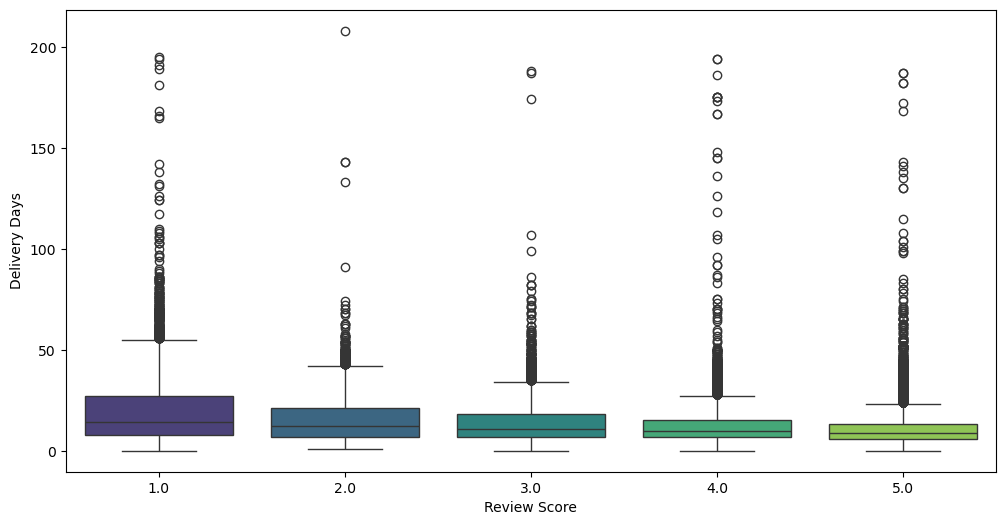

In [175]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df_delivery_segmentation['review_score'], y=df_delivery_segmentation['delivery_days'], palette='viridis')
plt.xlabel('Review Score')
plt.ylabel('Delivery Days')
plt.title('Delivery Days by Review Score', size=16, pad=10, fontweight='bold')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot (x=orders['review_score'], y=orders['delivery_days'], palette='summer')
plt.legend( bbox_to_anchor=(1.1, 0.88));

In [ ]:
df_delivery_segmentation.groupby('review_score')['delivery_days'].median()

review_score
1.0    14.0
2.0    12.0
3.0    11.0
4.0    10.0
5.0     9.0
Name: delivery_days, dtype: float64

In [ ]:
orders['bad_score'] = orders['review_score']<=3
orders.groupby('product_category_english')['bad_score'].mean().sort_values(ascending=False)